# PyTorch MNIST Lift and Shift Exercise

For this exercise notebook, use the `Python 3 (PyTorch 1.13 Python 3.9 CPU Optimized)` kernel on SageMaker Studio, or `conda_pytorch_p38` on classic SageMaker Notebook Instances.

---

## Introduction

Your new colleague in the data science team (who isn't very familiar with SageMaker) has written a nice notebook to tackle an image classification problem with PyTorch: [Local Notebook.ipynb](Local%20Notebook.ipynb).

It works OK with the simple MNIST data set they were working on before, but now they'd like to take advantage of some of the features of SageMaker to tackle bigger and harder challenges.

**Can you help refactor the Local Notebook code, to show them how to use SageMaker effectively?**


#### Reference
- [PyTorch MNIST](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-python-sdk/pytorch_mnist)

## Getting Started

First, check you can **run the [Local Notebook.ipynb](Local%20Notebook.ipynb) notebook through** - reviewing what steps it takes.

**This notebook** sets out a structure you can use to migrate code into, and lists out some of the changes you'll need to make at a high level. You can either work directly in here, or duplicate this notebook so you still have an unchanged copy of the original.

Try to work through the sections first with an MVP goal in mind (fitting the model to data in S3 via a SageMaker Training Job, and deploying/using the model through a SageMaker Endpoint). At the end, there are extension exercises to bring in more advanced functionality.


## Dependencies

Listing all our imports at the start helps to keep the requirements to run any script/file transparent up-front, and is specified by nearly every style guide including Python's official [PEP 8](https://www.python.org/dev/peps/pep-0008/#imports)


In [1]:
!pip install "ipycanvas<0.13" "ipywidgets<8" matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import glob
import os

# External Dependencies:
import matplotlib.pyplot as plt
import numpy as np

# Local Notebook Utils:
import util

# TODO: What else will you need?
# Have a look at the documentation: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html
# to see which libraries need to be imported to use sagemaker and the tensorflow estimator

## Prepare the Data

Let's download the image data from the Repository of Open Data on AWS and sample a subset like we did in the [Local Notebook.ipynb](Local%20Notebook.ipynb).

**Check you understand** what data it's going to upload from this notebook, and where it's going to store it in S3, then start the upload running while you work on the rest.

In [3]:
local_dir = "/tmp/mnist"
training_dir = f"{local_dir}/training"
testing_dir = f"{local_dir}/testing"

# Download the MNIST data from the Registry of Open Data on AWS
!rm -rf {local_dir}
!mkdir -p {local_dir}
!aws s3 cp s3://fast-ai-imageclas/mnist_png.tgz {local_dir} --no-sign-request

# Un-tar the MNIST data, stripping the leading path element; this will leave us with directories
# {local_dir}/testing/ and {local_dir/training/
!tar zxf {local_dir}/mnist_png.tgz -C {local_dir}/ --strip-components=1 --no-same-owner

# Get the list of files in tne training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# Reduce the data by keeping every Nth file and dropping the rest of the files.
reduction_factor = 2
train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# Delete all the files not to be kept
for fname in set(train_files) ^ set(train_files_to_keep):
    os.remove(fname)

for fname in set(test_files) ^ set(test_files_to_keep):
    os.remove(fname)

print("Done!")

download: s3://fast-ai-imageclas/mnist_png.tgz to ../../../../../../tmp/mnist/mnist_png.tgz
Training files: 60000
Testing files:  10000
Training files kept: 30000
Testing files kept:  5000
Done!


## Set Up Execution Role, Session and S3 Bucket

Now that we have downloaded and reduced the data in the local directory, we will need to upload it to Amazon S3 to make it available for Amazon Sagemaker training.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region.
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [4]:
# TODO: This is where you can setup execution role, session and S3 bucket.
# 1. Setup the SageMaker role
from sagemaker import get_execution_role
role = get_execution_role()

# 2. Setup the SageMaker session
import sagemaker
sess = sagemaker.Session()



# 3. Setup the SageMaker default bucket
bucket_name = sess.default_bucket()
print("bucket_name: \n", bucket_name)


# Have a look at the previous examples to find out how to do it

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/SageMaker/.xdg/config/sagemaker/config.yaml
bucket_name: 
 sagemaker-us-east-1-057716757052


## Upload Data to Amazon S3

Next is the part where you need to upload the images to Amazon S3 for Sagemaker training. You can refer to the previous example on how to do it using the [aws s3 sync](https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html) CLI command. The high-level command `aws s3 sync` command synchronizes the contents of the target bucket and source directory. It allows the use of options such as `--delete` that allows to remove objects from the target that are not present in the source and `--exclude` or `--include` options that filter files or objects to exclude or not exclude.

> ⏰ Note: Uploading to Amazon S3 typically takes about 2-3 minutes assuming a reduction_factor of 2.

In [5]:
# TODO: This is where you upload the training images using `aws s3 sync`.
# Fill in the missing source local directory and the target S3 bucket and folder in the command below.
import os

bucket_prefix = "sagemaker-mnist"
s3_data_location = os.path.join ('s3://', bucket_name, bucket_prefix)
print("s3_data_location: ", s3_data_location)

!aws s3 sync --quiet --delete {local_dir} {s3_data_location} --exclude "*.tgz" && echo "Done!"

s3_data_location:  s3://sagemaker-us-east-1-057716757052/sagemaker-mnist
Done!


In [6]:
! aws s3 ls {s3_data_location} 


                           PRE sagemaker-mnist/


In [7]:
! aws s3 ls {s3_data_location}sagemaker-mnist/training --recursive

In [8]:
! aws s3 ls s3://sagemaker-us-east-1-057716757052/sagemaker-mnist/training
! aws s3 ls s3://sagemaker-us-east-1-057716757052/sagemaker-mnist/testing

                           PRE training/
                           PRE testing/


You can check your data is uploaded by finding your bucket in the [Amazon S3 Console](https://s3.console.aws.amazon.com/s3/home). Do you see the folders of images as expected?

## Data Input ("Channels") Configuration

The draft code has **2 data sets**: One for training, and one for test/validation. (For classification, the folder location of each image is sufficient as a label).

In SageMaker terminology, each input data set is a "channel" and we can name them however we like... Just make sure you're consistent about what you call each one!

For a simple input configuration, a channel spec might just be the S3 URI of the folder. For configuring more advanced options, there's the [s3_input](https://sagemaker.readthedocs.io/en/stable/inputs.html) class in the SageMaker SDK.


In [9]:
# TODO: Define your 2 data channels
# The data can be found in: "s3://{bucket_name}/mnist/training" and "s3://{bucket_name}/mnist/testing"
# Look at the previous example to see how the inputs were defined
train_s3_path = f'{s3_data_location}/training'
test_s3_path = f'{s3_data_location}/testing'
inputs = { 
            'train': train_s3_path,
            'test' : test_s3_path
        }
print("inputs: ", inputs)


inputs:  {'train': 's3://sagemaker-us-east-1-057716757052/sagemaker-mnist/training', 'test': 's3://sagemaker-us-east-1-057716757052/sagemaker-mnist/testing'}


## Algorithm ("Estimator") Configuration and Run

Instead of loading and fitting this data here in the notebook, we'll be creating a [PyTorch Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-estimator) through the SageMaker SDK, to run the code on a separate container that can be scaled as required.

The ["Using PyTorch with the SageMaker Python SDK"](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) docs give a good overview of this process. You should run your estimator in **Python 3**.

**Use the [src/main.py](src/main.py) file** as your entry point to port code into - which has already been created for you with some basic hints.


## Naive script 로 훈련 실행

Before running the actual training on SageMaker TrainingJob, it can be good to run it locally first using the code below. If there is any error, you can fix them first before running using SageMaker TrainingJob.

In [10]:
save_model_dir = f"{local_dir}/model"
print("save_model_dir: ", save_model_dir)

save_model_dir:  /tmp/mnist/model


In [11]:
!python3 src/main-solution.py \
    --train_dir {training_dir} \
    --test_dir {testing_dir} \
    --output-data-dir data/local-output \
    --model-dir {save_model_dir} \
    --epochs=1 --batch-size=128

## Naive mode is set
## args: 
 Namespace(train_dir='/tmp/mnist/training', test_dir='/tmp/mnist/testing', model_dir='/tmp/mnist/model', output_data_dir='data/local-output', batch_size=128, test_batch_size=1000, epochs=1)
args.training data:  /tmp/mnist/training
args.test data:  /tmp/mnist/testing
##: Starting X, y dataset creation
Loading label 0...1...2...3...4...5...6...7...8...9...
Shuffling trainset...
Shuffling testset...
Done!
##: Starting preprocess
x_train shape: (30000, 1, 28, 28)
input_shape: (1, 28, 28)
30000 train samples
5000 test samples
n_labels: 10
y_train shape: (30000, 10)
##: trainloader is successfully loaded 
##: testloader is successfully loaded 
## Start training 
epoch: 1
train_loss: 0.000796
Evaluating model
## Start testing 
val_loss: 0.0338
val_acc: 0.9434
Saving model at /tmp/mnist/model/model.pth
## model is saved at /tmp/mnist/model/model.pth


When you're ready to try your script in a Sagemaker training job, you can call `estimator.fit()` as we did in previous exercises:

## 로컬 모드 혹은 클라우드 모드 사용

In [12]:
# USE_LOCAL_MODE = True
USE_LOCAL_MODE = False

import torch

if USE_LOCAL_MODE:
    instance_type = 'local_gpu' if torch.cuda.is_available() else 'local'
    instance_count = 1
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    print("## Local mode is set")

else:
    instance_type = 'ml.g5.2xlarge'
    instance_count = 1
    sagemaker_session = sagemaker.session.Session()
    print(f"## Cloud mode is set with {instance_type} and {instance_count} of instance_count")

## Cloud mode is set with ml.g5.2xlarge and 1 of instance_count


In [13]:
import boto3
region = boto3.Session().region_name

image_uri = '763104351884.dkr.ecr.{}.amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker'.format(region)
print("image_uri: \n", image_uri)


image_uri: 
 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker


In [14]:
bUseTrainWarmPool = True ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None

In [15]:
# TODO: Create your PyTorch estimator

# Note the PyTorch class inherits from some cross-framework base classes with additional
# constructor options:
# https://sagemaker.readthedocs.io/en/stable/estimators.html
# https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#create-an-estimator

# We are using PyTorch 1.8 and python 3
# You can reuse the metrics definition from the previous example
# (Optional) Look at the Pytorch script and try to pass new hyperparameters
from sagemaker.pytorch import PyTorch

# define Training Job Name 
import time
job_name = f'sagemaker-101-pytorch-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'


estimator = PyTorch(entry_point = 'main-solution.py',
                    source_dir = 'src',
                    image_uri = image_uri,
                    instance_type= instance_type,
                    instance_count=1,
                    base_job_name= job_name,    
                    role = role,
                    sagemaker_session=sagemaker_session,
                    framework_version='1.8.0',
                    py_version='py3',
                    keep_alive_period_in_seconds=nKeepAliveSeconds,
)


In [16]:
# TODO: Call estimator.fit
estimator.fit(inputs, wait=False)
train_job_name = estimator.latest_training_job.job_name

INFO:sagemaker:Creating training-job with name: sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-26-33-734


### SageMaker training job, cloudwatch log 보기

In [17]:
from IPython.display import display, HTML


def make_console_link(region, train_job_name, train_task='[Training]'):
    train_job_link = f'<b> {train_task} Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{train_job_name}">Training Job</a></b>'   
    cloudwatch_link = f'<b> {train_task} Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={region}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={train_job_name};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a></b>'
    return train_job_link, cloudwatch_link  
        
if ~USE_LOCAL_MODE:
    train_job_link, cloudwatch_link = make_console_link(region, train_job_name, '[PyTorch DeepSpeed Training]')
    display(HTML(train_job_link))
    display(HTML(cloudwatch_link))

### 훈련 잡의 로그 보기

In [18]:
estimator.logs()

2024-06-19 14:26:35 Starting - Starting the training job
2024-06-19 14:26:35 Pending - Training job waiting for capacity.....................
2024-06-19 14:29:45 Downloading - Downloading input data..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-19 14:30:11,215 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-19 14:30:11,236 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-19 14:30:11,247 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-06-19 14:30:11,249 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-06-19 14:30:11,503 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-19 14:30:11,536 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-19 14:30:11,

## Deploy and Use Your Model (Real-Time Inference)

If your training job has completed; and saved the model in the correct PyTorch model format; it should now be pretty simple to deploy the model to a real-time endpoint.

You can achieve this with the [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html).

In [19]:
# TODO: Deploy a real-time endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-26-33-734/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-26-33-734/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-31-18-636/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-31-18-636
INFO:sagemaker:Creating endpoint-config with name sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-31-18-636
INFO:sagemaker:Creating endpoint with name sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-31-18-636


---------------------------------------------------------------*

UnexpectedStatusException: Error hosting endpoint sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-31-18-636: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.. Try changing the instance type or reference the troubleshooting page https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-troubleshooting.html

# 로컬 추론 테스트

### 훈련 아티펙트 다운로드

In [20]:
model_s3_path = estimator.model_data
print("model_s3_path: \n", model_s3_path)

local_model_dir = 'local_model'
os.makedirs(local_model_dir, exist_ok=True)

model_s3_path: 
 s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-26-33-734/output/model.tar.gz


In [21]:
%%sh -s {model_s3_path} {local_model_dir}

model_s3_path=$1
local_model_dir=$2
# 모델을 S3에서 로컬로 다운로드
aws s3 cp $model_s3_path $local_model_dir

# 모델 다운로드 폴더로 이동
cd $local_model_dir

# 압축 해제
tar -xvf model.tar.gz

download: s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-19-14-26--2024-06-19-14-26-33-734/output/model.tar.gz to local_model/model.tar.gz


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


model.pth


## 추론 함수 정의

### 모델 로딩 함수

In [22]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

local_model_dir = 'local_model'

device:  cuda


In [41]:
import os

def model_fn(model_dir):
    '''
    Load a model
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.jit.load(os.path.join(model_dir, 'model.pth'))
    model = model.to(device)
    print("Model is successfully loaded")
    model.eval()
    return model

model = model_fn(local_model_dir)

Model is successfully loaded


### input_fn 준비

In [46]:
import json 

def create_payload(label, testing_dir):
    filename = os.listdir(f"{testing_dir}/{label}")[0]

    # Load the image:
    img = Image.open(f"{testing_dir}/{label}/{filename}")
    # normalize
    input_data = np.asarray(img).astype(np.float32) / 255
    input_data = np.expand_dims(input_data, [0, 1])  # Add batch & leading channel dim
    input_data = input_data.flatten().tolist()
    print("input_data: ", np.shape(input_data))

    payload = {
        'input': input_data, # input_data
        'resolution' : [28, 28]
    }

    return json.dumps(payload)

payload = create_payload(label=2, testing_dir=testing_dir)
print("payload: \n", payload)

input_data:  (784,)
payload: 
 {"input": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24705882370471954, 1.0, 0.9921568632125854, 0.9098039269447327, 0.4274509847164154, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5647059082984924, 0.9921568632125854, 0.9882352948188782, 0.9882352948188782, 0.9882352948188782, 0.6117647290229797, 0.03921568766236305, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0235294122248888, 0.6274510025978088, 0

In [47]:
import os
def input_fn(input_data, content_type):
    if content_type == 'application/json':
        data = json.loads(input_data)["input"]
        resolution = json.loads(input_data)["resolution"]
        
        data = np.array(data).reshape(resolution)
        data = np.squeeze(data).astype(np.float32) / 255
        data = torch.tensor(data).unsqueeze(0).unsqueeze(0)    
        print("np.shape: ", np.shape(data))

        
    return data




input_data = input_fn(input_data=payload, content_type='application/json')


# # Load the image:
# img = Image.open(f"{testing_dir}/{label}/{filename}")
# input_data = np.asarray(img).astype(np.float32) / 255
# input_data_shape = np.shape(input_data)
# input_data = input_data.flatten()
# np.shape(input_data)
# input_data = input_data.reshape(input_data_shape)
# np.shape(input_data)
# input_data = torch.tensor(input_data).unsqueeze(0).unsqueeze(0)    
    

# normalize
# input_data = np.asarray(img).astype(np.float32) / 255


# input_fn2(input_data, request_content_type=None)


np.shape:  torch.Size([1, 1, 28, 28])


In [48]:
# import json 

# def input_fn(input_data, content_type=None):
#     if content_type == 'application/json':
#         input_data = json.loads(request_body)
        
#     return input_data

# label =2
# filename = os.listdir(f"{testing_dir}/{label}")[0]

# # Load the image:
# img = Image.open(f"{testing_dir}/{label}/{filename}")
# # normalize
# input_data = np.asarray(img).astype(np.float32) / 255
# input_data = np.expand_dims(input_data, [0, 1])  # Add batch & leading channel dim

# # payload = {
# #     'input_data': [1,2,3] # input_data
# # }


# # JSON 형식으로 입력 데이터 직렬화
# # serialized_input_data = json.dumps(payload)
# input_data = input_fn(input_data=input_data, content_type=None)
# # input_data = input_fn(input_data=serialized_input_data, content_type=None)

# print("input_data shape: ", np.shape(input_data))
# input_data = torch.Tensor(input_data)
# print("type: ", type(input_data))
# # input_data



### predict_fn 준비

In [49]:
def predict_fn(input_data, model):
    '''
    모델의 추론 함수
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_data = input_data.to(device)
    print("shape: ", np.shape(input_data))
    
    with torch.no_grad():
        result = model(input_data)
    print(f"Result confidences: {result}")

    return result

result = predict_fn(input_data=input_data, model=model)
max_index = torch.argmax(result).item()    
print("Max confidence index:", max_index)

shape:  torch.Size([1, 1, 28, 28])
Result confidences: tensor([[0.0832, 0.1261, 0.0860, 0.0936, 0.0987, 0.1245, 0.0859, 0.1089, 0.0866,
         0.1066]], device='cuda:0')
Max confidence index: 1


In [32]:
def output_fn(prediction, content_type):
    return json.dumps(prediction)

Reviewing the architecture from the example notebook, we set up the model to accept **batches** of **28x28** image tensors with **normalized 0-1 pixel values** and a **single color channel dimension**.

Assuming you haven't [added any custom inference pre-processing](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#serve-a-pytorch-model) to the script (for example to accept encoded JPEGs/PNGs, or arbitrary image shapes), we'll need to replicate that same format when we use our endpoint.

You can use the final "Explore Results" section of the local notebook as a guide. First, using the interactive widget:

### 전체 로컬 추론 테스트

In [42]:
from PIL import Image

# Choose an image:

def predict_mnist(label, local_model_dir, testing_dir ):

    # Handle input
    # Load the image:
    filename = os.listdir(f"{testing_dir}/{label}")[0]
    img = Image.open(f"{testing_dir}/{label}/{filename}")
    # normalize
    input_data = np.squeeze(np.asarray(img)).astype(np.float32) / 255
    input_data = torch.tensor(np.expand_dims(input_data, [0, 1]))  # Add batch & leading channel dim
    
    # call input_fn as dummy
    # input_data = input_fn(input_data=input_data, content_type=None)

    print("input_data shape: ", np.shape(input_data))

    # load model
    model = model_fn(local_model_dir)

    # predict label
    result = predict_fn(input_data=input_data, model=model)
    max_index = torch.argmax(result).item()    
    print("Max confidence index:", max_index)
    
    # input_data = np.squeeze(np.asarray(img)).astype(np.float32) / 255
    # input_data = torch.tensor(np.expand_dims(input_data, [0, 1]))  # Add batch & leading channel dim

    # # Send to the model:
    # with torch.no_grad():
    #     result = model(input_data)
    # print(f"Result confidences: {result}")

    # Plot the result:
    plt.figure(figsize=(3, 3))
    fig = plt.subplot(1, 1, 1)
    ax = plt.imshow(img, cmap="gray")
    fig.set_title(f"Predicted Number {max_index}")
    plt.show()


input_data shape:  torch.Size([1, 1, 28, 28])
Model is successfully loaded
shape:  torch.Size([1, 1, 28, 28])
Result confidences: tensor([[2.5125e-05, 2.6190e-05, 1.2528e-05, 9.5807e-01, 2.0152e-07, 4.1812e-02,
         9.5869e-07, 1.2248e-06, 1.6725e-05, 3.0621e-05]], device='cuda:0')
Max confidence index: 3


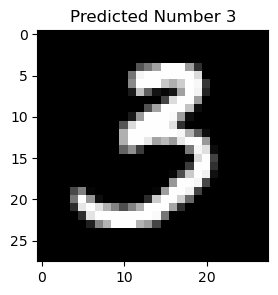

In [43]:


predict_mnist(label=3, local_model_dir=local_model_dir, testing_dir=testing_dir )    

input_data shape:  torch.Size([1, 1, 28, 28])
Model is successfully loaded
shape:  torch.Size([1, 1, 28, 28])
Result confidences: tensor([[2.7935e-06, 3.8688e-07, 9.7736e-07, 6.1744e-04, 1.4950e-04, 5.7962e-04,
         2.3083e-08, 6.4018e-03, 4.6521e-05, 9.9220e-01]], device='cuda:0')
Max confidence index: 9


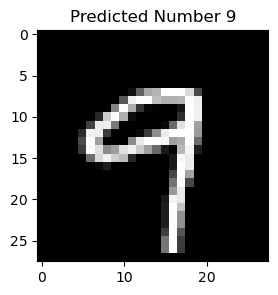

In [44]:
predict_mnist(label=9, local_model_dir=local_model_dir, testing_dir=testing_dir )    

## SageMaker Endpoint

In [75]:
from src.inference import model_fn , input_fn, predict_fn

import os
import time
import sagemaker
from sagemaker.pytorch.model import PyTorchModel

In [76]:
local_model_path = os.path.join(local_model_dir, 'model.tar.gz')
print("local_model_path: ", local_model_path)

local_model_path:  local_model/model.tar.gz


In [77]:
instance_type = 'local_gpu' if torch.cuda.is_available() else 'local'
print("Instance type = " + instance_type)

Instance type = local_gpu


In [78]:
import time
endpoint_name = "local-endpoint-mnist-{}".format(int(time.time()))

local_pytorch_model = PyTorchModel(model_data=local_model_path,
                                   role=role,
                                   entry_point='inference.py',
                                   source_dir = 'src',
                                   framework_version='2.0.1',
                                   py_version='py310',
                                   model_server_workers=1,
                                  )

local_predictor = local_pytorch_model.deploy(
                           instance_type=instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                           log = False,
                        )

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Repacking model artifact (local_model/model.tar.gz), script artifact (src), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-057716757052/pytorch-inference-2024-06-18-15-27-07-974/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-06-18-15-27-08-757
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating endpoint-config with name local-endpoint-mnist-1718724427
INFO:sagemaker.tele

Attaching to xqkzxa2pae-algo-1-7fodr
xqkzxa2pae-algo-1-7fodr  | ['torchserve', '--start', '--model-store', '/.sagemaker/ts/models', '--ts-config', '/etc/sagemaker-ts.properties', '--log-config', '/opt/conda/lib/python3.10/site-packages/sagemaker_pytorch_serving_container/etc/log4j2.xml', '--models', 'model=/opt/ml/model']
xqkzxa2pae-algo-1-7fodr  | Warning: TorchServe is using non-default JVM parameters: -XX:-UseContainerSupport
xqkzxa2pae-algo-1-7fodr  | WARNING: sun.reflect.Reflection.getCallerClass is not supported. This will impact performance.
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:12,501 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:12,504 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:

INFO:sagemaker.local.entities:Checking if serving container is up, attempt: 10


xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,276 [INFO ] pool-2-thread-2 ACCESS_LOG - /172.19.0.1:56232 "GET /ping HTTP/1.1" 200 12
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,277 [INFO ] pool-2-thread-2 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:fc5fecc824a6,timestamp:1718724434
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,427 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - s_name_part0=/home/model-server/tmp/.ts.sock, s_name_part1=9000, pid=103
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,429 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Listening on port: /home/model-server/tmp/.ts.sock.9000
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,438 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Successfully loaded /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml.
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,439 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - [PID]103
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:27:14,439 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - To

## 엔드포인트 추론

In [86]:
from sagemaker.serializers import JSONSerializer
# local_predictor.serializer = JSONSerializer('application/json')


filename = os.listdir(f"{testing_dir}/{label}")[0]
img = Image.open(f"{testing_dir}/{label}/{filename}")
input_data = np.squeeze(np.asarray(img)).astype(np.float32) / 255
# input_data = torch.tensor(np.expand_dims(input_data, [0, 1]))  # Add batch & leading channel dim
input_data = np.expand_dims(input_data, [0, 1])  # Add batch & leading channel dim
print("shape of input_data: ", np.shape(input_data))


shape of input_data:  (1, 1, 28, 28)


In [87]:
result = local_predictor.predict(input_data)
result
# local_predictor.predict(json.dumps(payload))

xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,973 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:fc5fecc824a6,timestamp:1718724908
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,975 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1718724908975
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,979 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Model is successfully loaded
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,979 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1718724908
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,980 [INFO ] W-9000-model_1.0 ACCESS_LOG - /172.19.0.1:55862 "POST /invocations HTTP/1.1" 500 11
xqkzxa2pae-algo-1-7fodr  | 2024-06-18T15:35:08,981 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:0.6|#ModelName:model,Level:Model|#hostname:f

ValueError: Please set the param allow_pickle=True                         to deserialize pickle objects in NumpyDeserializer

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 955, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 1021, in _stream_output
    raise RuntimeError(f"Failed to run: {process.args}. Process exited with code: {exit_code}")
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpy952j82r/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit']. Process exited with code: 137

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 960, in run
    raise RuntimeEr

xqkzxa2pae-algo-1-7fodr exited with code 137


## Clean-Up

Remember to clean up any persistent resources that aren't needed anymore to save costs: The most significant of these are real-time prediction endpoints, and this SageMaker Notebook Instance.

The SageMaker SDK [Predictor](https://sagemaker.readthedocs.io/en/stable/predictors.html) class provides an interface to clean up real-time prediction endpoints; and SageMaker Notebook Instances can be stopped through the SageMaker Console when you're finished.

You might also like to clean up any S3 buckets / content we created, to prevent ongoing storage costs.


In [ ]:
# TODO: Clean up any endpoints/etc to release resources